In [666]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import defaultdict


In [513]:
#df_TY_features = pd.read_parquet(file_name_TY_features1)
df_TY_users = pd.read_parquet("/Users/wendyessilfie/Documents/GitHub/Business-statistics-/TaoYin_User_Transactions.parquet")

1. FEATURE ENGINEERING of CUSTOMERS by PROFIT

In [514]:
# Calculate the 'profit' column using the formula (sum2 - sum1)
df_TY_users.loc[:,"profit"] = (df_TY_users["sum2"] - df_TY_users["sum1"])
df_TY_users.head()

,customer,invoice,invoice_date,artikelnr,volume,sum1,sum2,postcode_delivery,postcode_customer,channel,profit
0,2284,1187467,2020-01-02,6439980,24,343.73,362.30,80413,80413,Tel 86041,18.57
1,2284,1187467,2020-01-02,6439981,60,1067.64,1119.96,80413,80413,Tel 86041,52.32
2,2284,1187467,2020-01-02,6420905,120,2214.00,2408.40,80413,80413,Tel 86041,194.40
3,1704,1191447,2020-01-17,8433401,1,21.52,19.32,81724,81724,OTC 81812,-2.20
4,45,1187691,2020-01-03,7180136,4,28.91,28.49,81796,81796,Web Order,-0.42


In [516]:
df_TY_customer_merged = df_TY_users.groupby("customer").agg({'profit' : ['sum'], 'sum2' : ['sum']}).reset_index()
df_TY_customer_merged.head(10)

# Flatten the column index
df_TY_customer_merged.columns = ['_'.join(col).strip() for col in df_TY_customer_merged.columns.values]

# Rename sales column
df_TY_customer_merged = df_TY_customer_merged.rename(columns={'sum2_sum': 'sales_sum'})

# Display the DataFrame
print(df_TY_customer_merged.head(10))

   customer_  profit_sum   sales_sum
0          0       -2.53       13.72
1          3    10263.09   712214.87
2          4     -736.60     3135.02
3          5    -2220.25     2199.45
4          6       -8.89       99.48
5         14    33219.18  1397887.79
6         17    -1381.80      205.80
7         21       35.63      294.17
8         22     -126.29     1048.19
9         30       -8.49      289.87


In [517]:
column_sum1 = df_TY_customer_merged['profit_sum'].sum()
column_sum2 = df_TY_customer_merged['sales_sum'].sum()
print("Sum of Profit:", int(column_sum1))
print("Sum of Sales:", int(column_sum2))

Sum of Profit: 13312202
Sum of Sales: 127824304


Intermediate conclusion 1.1: The company is profitable with a margin of ~10%

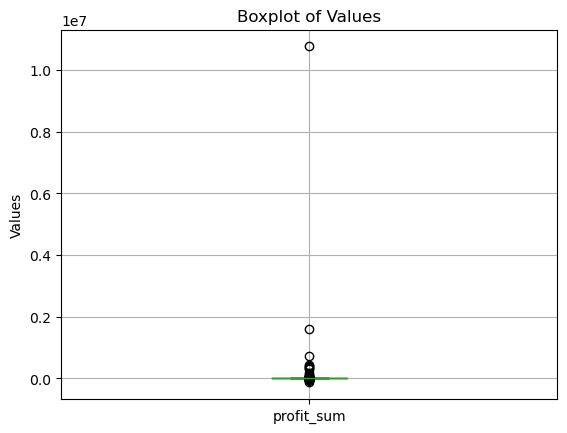

In [518]:
df_TY_customer_merged.boxplot(column='profit_sum')

# Labeling the axes
plt.title('Boxplot of Values')
plt.ylabel('Values')

# Show the plot
plt.show()

Intermediate conclusion 1.2: There are outliers which will distort my analysis. I need to take care of these outliers. 

In [520]:
# Extract the outliers

median = df_TY_customer_merged['profit_sum'].median()
mad = (df_TY_customer_merged['profit_sum'] - median).abs().median()

# Calculate modified Z-scores
df_TY_customer_merged['Modified Z-Score'] = 0.6745 * (df_TY_customer_merged['profit_sum'] - median) / mad

# Identify outliers
outliers = df_TY_customer_merged[df_TY_customer_merged['Modified Z-Score'].abs() > 3.5]

outlier_customers = outliers['customer_'].tolist()
#print(outlier_customers)
print("Outliers using Z-score:")
print(outliers)

Outliers using Z-score:
      customer_  profit_sum   sales_sum  Modified Z-Score
1             3    10263.09   712214.87         23.966517
3             5    -2220.25     2199.45         -4.621446
5            14    33219.18  1397887.79         76.538013
12           40    -2287.33    19653.09         -4.775065
14           42    -2465.45   104423.75         -5.182976
...         ...         ...         ...               ...
1060       2478    23093.03   149798.85         53.348226
1062       2486     6255.48    33897.85         14.788733
1064       2488     5513.15   224654.12         13.088731
1066       2492    -3160.73    15763.15         -6.775229
1069       2500   -13025.00    50832.34        -29.365288

[291 rows x 4 columns]


In [523]:
# Check if there are any infinite values in the margins_sum column
print(df_TY_customer_merged['profit_sum'].isin([np.inf, -np.inf]).sum())

# Replace infinite values with NaN
df_TY_customer_merged['profit_sum'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Optionally, fill NaN values with the maximum of the non-infinite data
df_TY_customer_merged['profit_sum'].fillna(df_TY_customer_merged['profit_sum'].max(), inplace=True)


0


/var/folders/fh/wbkbplv94qz11z3b8wk1mrmw0000gn/T/ipykernel_55700/180137320.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_TY_customer_merged['profit_sum'].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/fh/wbkbplv94qz11z3b8wk1mrmw0000gn/T/ipykernel_55700/180137320.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object o

In [524]:
# Determine the min and max values of 'profit_sum' to create bins without the outliers
filtered_df = df_TY_customer_merged[~df_TY_customer_merged['customer_'].isin(outlier_customers)]
min_profit = filtered_df['profit_sum'].min()
max_profit = filtered_df['profit_sum'].max()

# Create evenly spaced bins for margins using min and max values
bins = np.linspace(min_profit, max_profit, num=6)  # Creates 5 equal-width intervals
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Create profit categories based on these equal-width bins
df_TY_customer_merged['profit_category'] = pd.cut(df_TY_customer_merged['profit_sum'], bins=bins, labels=labels, include_lowest=True)
df_TY_customer_merged.loc[df_TY_customer_merged['profit_sum'] > max_profit, 'profit_category'] = 'Very High' # bring the outliers back
df_TY_customer_merged.loc[df_TY_customer_merged['profit_sum'] < min_profit, 'profit_category'] = 'Very Low'  # bring the outliers back

# Sort by margin category and volume
sorted_df = df_TY_customer_merged.sort_values(by=['profit_category', 'sales_sum'], ascending=[True, False]).reset_index()

# Display the sorted dataframe
#print(sorted_df[['customer_', 'profit_sum', 'sales_sum', 'profit_category']].head(20))
sorted_df['profit_category'].value_counts()


profit_category
Medium       526
Very Low     286
Low          113
Very High     76
High          69
Name: count, dtype: int64

In [526]:
# Create evenly spaced bins for margins
bins = 5  # This creates 5 equal-width intervals
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Create margin categories based on equal-width bins
df_TY_customer_merged['margin_category'] = pd.cut(df_TY_customer_merged['profit_sum'], bins=bins, labels=labels)

# Sort by margin category and volume
sorted_df = df_TY_customer_merged.sort_values(by=['margin_category', 'volume_sum'], ascending=[True, False])

# Display the sorted dataframe
sorted_df[['customer_', 'profit_sum', 'volume_sum', 'margin_category']].head(20)


KeyError: 'volume_sum'

In [527]:
df_TY_customer_merged["margin_category"].value_counts()['Very High']

1

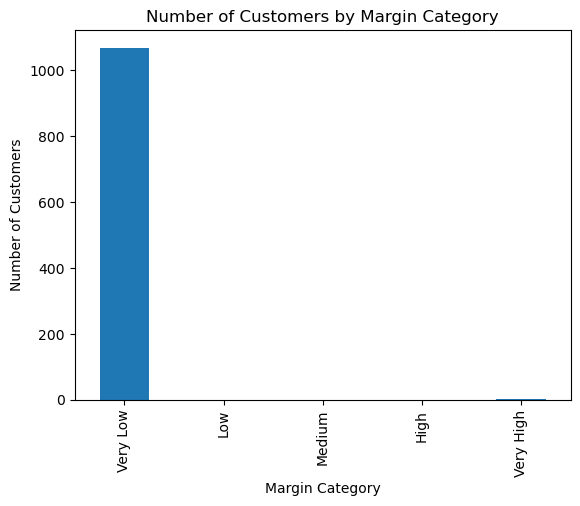

In [529]:
# Plot the number of customers in each margin category
df_TY_customer_merged['margin_category'].value_counts().sort_index().plot(kind='bar')

# Add labels and title
plt.xlabel('Margin Category')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Margin Category')

# Show the plot
plt.show()

In [530]:
df_TY_customer_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customer_         1070 non-null   int64   
 1   profit_sum        1070 non-null   float64 
 2   sales_sum         1070 non-null   float64 
 3   Modified Z-Score  1070 non-null   float64 
 4   profit_category   1070 non-null   category
 5   margin_category   1070 non-null   category
dtypes: category(2), float64(3), int64(1)
memory usage: 36.1 KB


In [531]:
# ----- vanessa -----
# Get unique values from 'postcode_customer' column
# customer_postcode_set = df_TY_users['postcode_customer'].unique()

# Convert the list of unique values to a set
# customer_set = set(customer_postcode_set)

# Print count of unique values
# print("Count: ", len(customer_set))

count_customer_postcode = df_TY_users['postcode_customer'].nunique()
print(count_customer_postcode)

593


In [532]:
# Get unique values from 'postcode_delivery' column
# delivery_postcode_set = df_TY_users['postcode_delivery'].unique()

# Convert the list of unique values to a set
# delivery_set = set(delivery_postcode_set)

# Print count of unique values
# print("Count: ", len(delivery_set))

count_delivery_postcode = df_TY_users['postcode_delivery'].nunique()
print(count_delivery_postcode)

659


In [533]:
# difference between no of unique delivery postcodes and the customer postcodes
dropshippers_count = count_delivery_postcode - count_customer_postcode

print(dropshippers_count)

66


In [535]:
# ----- wendy -----
mismatched_postcode = df_TY_users[df_TY_users["postcode_delivery"] != df_TY_users["postcode_customer"]]
print(f"Number of mismatched row and columns: {mismatched_postcode.shape}")

# Step 3: Optionally, you can display a sample of mismatched rows to verify
mismatched_postcode.head(20)


Number of mismatched row and columns: (71089, 11)


,customer,invoice,invoice_date,artikelnr,volume,sum1,sum2,postcode_delivery,postcode_customer,channel,profit
19,1236,1187648,2020-01-03,3025558,100,22.70,28.78,81620,81689,ERP Order,6.08
20,1236,1187648,2020-01-03,6205512,400,12.58,14.00,81620,81689,ERP Order,1.42
75,595,1189396,2020-01-10,8591166,1,179.91,194.23,85004,81716,Tel 81812,14.32
76,595,1189396,2020-01-10,8591372,1,26.14,26.66,85004,81716,Tel 81812,0.52
77,595,1189396,2020-01-10,8590531,2,57.25,59.00,85004,81716,Tel 81812,1.75
78,595,1189396,2020-01-10,8591737,2,81.64,71.67,85004,81716,Tel 81812,-9.97
79,595,1189396,2020-01-10,8590572,2,23.90,23.79,85004,81716,Tel 81812,-0.11
80,595,1189396,2020-01-10,8590630,15,13.10,14.65,85004,81716,Tel 81812,1.55
81,595,1189396,2020-01-10,8590721,15,14.95,14.65,85004,81716,Tel 81812,-0.30
82,595,1189396,2020-01-10,8590788,10,9.97,9.77,85004,81716,Tel 81812,-0.20


In [671]:
# Step 1: Identify customers where postcodes are the same (non-dropshippers)
same_postcode = df_TY_users['postcode_delivery'] == df_TY_users['postcode_customer']

# Step 2: Identify customers with consistent mismatched postcodes (retailers)
consistent_mismatch = df_TY_users.groupby('customer').apply(
    lambda x: (x['postcode_delivery'].nunique() == 1) and (x['postcode_customer'].nunique() == 1) and (not same_postcode[x.index].all())
)

# Step 3: Assign default category 'dropshipper' to all customers
df_TY_users['customer_type'] = 'dropshipper'

# Step 4: Update 'customer_type' for non-dropshippers and retailers
df_TY_users.loc[same_postcode, 'customer_type'] = 'non-dropshipper'
df_TY_users.loc[df_TY_users['customer'].isin(consistent_mismatch[consistent_mismatch].index), 'customer_type'] = 'retailer'

# Step 5: Group by customer and get the first occurrence of each customer to create a grouped DataFrame
grouped_df = df_TY_users.groupby('customer').first().reset_index()

# Resulting grouped DataFrame
grouped_df.head()

/var/folders/fh/wbkbplv94qz11z3b8wk1mrmw0000gn/T/ipykernel_55700/3665725691.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  consistent_mismatch = df_TY_users.groupby('customer').apply(


,customer,invoice,invoice_date,artikelnr,volume,sum1,sum2,postcode_delivery,postcode_customer,channel,profit,customer_type
0,0,1258126,2020-10-06,7287771,1,16.25,13.72,81131,81131,Tel 81812,-2.53,non-dropshipper
1,3,1228666,2020-06-04,7195019,1,9.79,8.32,89207,89207,OTC 89206,-1.47,non-dropshipper
2,4,1418519,2022-07-12,7901911,1,43.02,34.57,89221,89221,OTC 89206,-8.45,non-dropshipper
3,5,1200226,2020-02-18,4238056,1,16.25,14.40,84849,84849,Tel 84817,-1.85,non-dropshipper
4,6,1327185,2021-07-02,7803174,1,53.39,48.52,89222,89222,OTC 89206,-4.87,non-dropshipper


In [538]:
grouped_df["customer_type"].value_counts()

customer_type
non-dropshipper    857
retailer           154
dropshipper         59
Name: count, dtype: int64

In [558]:
# Filter grouped_df to include only rows where customer_type is 'dropshipper'
dropshipper_df = grouped_df[grouped_df['customer_type'] == 'dropshipper'].reindex()

# Display the resulting DataFrame with only drop shippers
dropshipper_df.head()


,customer,invoice,invoice_date,artikelnr,volume,sum1,sum2,postcode_delivery,postcode_customer,channel,profit,customer_type
17,48,1230159,2020-06-09,4224408,50,122.55,193.90,83990,89301,Tel 89206,71.35,dropshipper
36,104,1203539,2020-02-28,8710824,2,10.24,10.64,83192,83194,Tel 83047,0.40,dropshipper
52,144,1197387,2020-02-06,3030285,50,96.38,110.74,89203,89206,OTC 89206,14.36,dropshipper
53,145,1243622,2020-07-31,8436065,1,28.95,27.87,86043,86049,OTC 86041,-1.08,dropshipper
58,156,1193214,2020-01-23,6101257,100,66.45,61.93,89230,89231,Tel 89206,-4.52,dropshipper


In [562]:
# Group by 'customer' and calculate total shipments, customer type, and total drop shipments
#tot_shipments_sum = df_TY_users.groupby('customer').agg(
   #tot_shipments=('customer', 'count'),  # Total number of shipments per customer
    #customer_type=('customer_type', 'first'),  # Consistent customer type for each customer
    #tot_dropshipments=('customer_type', lambda x: sum(x == 'dropshipper'))  # Count of shipments only if 'dropshipper'
#).reset_index()

# Display the resulting DataFrame
#tot_shipments_sum.head(50)



In [673]:
# Group by 'customer' and calculate total shipments, customer type, and total drop shipments only for drop shippers
tot_shipments_sum = df_TY_users.groupby('customer').agg(
    tot_shipments=('customer', 'count'),  # Total number of shipments per customer
    customer_type=('customer_type', 'first'),  # Consistent customer type for each customer
    tot_dropshipments=('customer_type', lambda x: sum(x == 'dropshipper') if x.iloc[0] == 'dropshipper' else 0)
).reset_index()

# Display the resulting DataFrame
tot_shipments_sum.head()


,customer,tot_shipments,customer_type,tot_dropshipments
0,0,1,non-dropshipper,0
1,3,2432,non-dropshipper,0
2,4,109,non-dropshipper,0
3,5,33,non-dropshipper,0
4,6,3,non-dropshipper,0


In [567]:
# Calculate the percentage of drop shipments for each customer
tot_shipments_sum["percentage_DS"] = (tot_shipments_sum["tot_dropshipments"] / tot_shipments_sum["tot_shipments"]) * 100

# Filter the DataFrame to show only rows where the customer type is 'dropshipper'
dropshipper_only = tot_shipments_sum[tot_shipments_sum["customer_type"] == "dropshipper"]

# Display the resulting DataFrame with only drop shippers
dropshipper_only.head()


,customer,tot_shipments,customer_type,tot_dropshipments,percentage_DS
17,48,21,dropshipper,21,100.000000
36,104,21,dropshipper,15,71.428571
52,144,576,dropshipper,387,67.187500
53,145,53,dropshipper,45,84.905660
58,156,259,dropshipper,200,77.220077


In [568]:
# Viewing the highest and lowest percentage of dropshipments over the total per customer
print(dropshipper_only["percentage_DS"].max())
print(dropshipper_only["percentage_DS"].min())


100.0
8.823529411764707


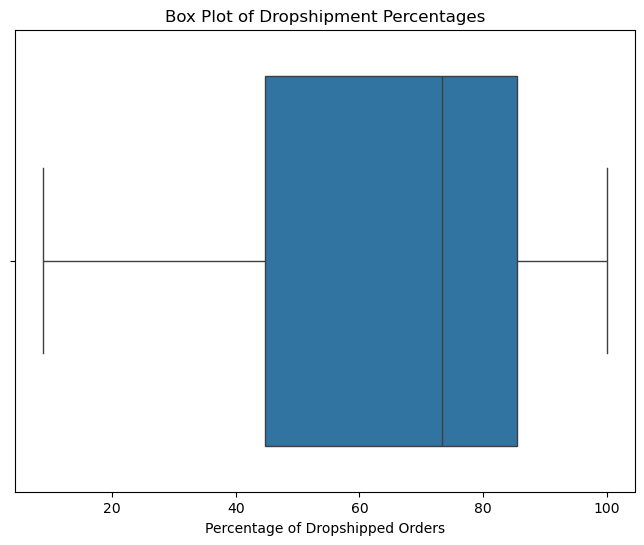

In [571]:
#plotting a boxplot to see what the distribution looks like
plt.figure(figsize=(8, 6))
sns.boxplot(x=dropshipper_only['percentage_DS'])
plt.title('Box Plot of Dropshipment Percentages')
plt.xlabel('Percentage of Dropshipped Orders')
plt.show()

In [675]:
# Create a copy of dropshipper_only to avoid SettingWithCopyWarning
dropshipper_only = dropshipper_only.copy()

# Define bins and labels for categorizing 'percentage_DS'
bins = 5  # Number of equal-width intervals
labels = ['Very low', 'Low', 'Medium', 'High', 'Very high']

# Create margin categories based on equal-width bins
dropshipper_only['category_dropshipping'] = pd.cut(dropshipper_only['percentage_DS'], bins=bins, labels=labels)

# Sort by margin category (ascending)
sorted_dropshipments = dropshipper_only.sort_values(by='category_dropshipping', ascending=True)

# Display the sorted dataframe
sorted_dropshipments.head()


,customer,tot_shipments,customer_type,tot_dropshipments,percentage_DS,category_dropshipping
982,2298,16,dropshipper,2,12.500000,Very low
835,1979,91,dropshipper,10,10.989011,Very low
762,1823,1079,dropshipper,217,20.111214,Very low
135,347,154,dropshipper,27,17.532468,Very low
168,453,366,dropshipper,98,26.775956,Very low


In [612]:
volume_sum_df = df_TY_users.groupby('customer').agg(volume_sum=('volume', 'sum'),      # Sum of volumes for each customer
).reset_index()

# Display the resulting aggregated DataFrame
volume_sum_df

,customer,volume_sum
0,0,1
1,3,293321
2,4,1315
3,5,161
4,6,3
...,...,...
1065,2491,342
1066,2492,3634
1067,2493,84
1068,2496,117


In [630]:

# Group by 'customer' and calculate the sum of volumes for each customer
volume_sum_df = df_TY_users.groupby('customer').agg(
    volume_sum=('volume', 'sum')  # Sum of volumes for each customer
).reset_index()

# Add a new column for the log of volume_sum
# Using np.log1p to safely handle cases where volume_sum might be zero
volume_sum_df['log_volume_sum'] = np.log1p(volume_sum_df['volume_sum'])

# Display the resulting DataFrame with the log-transformed column
volume_sum_df


,customer,volume_sum,log_volume_sum
0,0,1,0.693147
1,3,293321,12.589026
2,4,1315,7.182352
3,5,161,5.087596
4,6,3,1.386294
...,...,...,...
1065,2491,342,5.837730
1066,2492,3634,8.198364
1067,2493,84,4.442651
1068,2496,117,4.770685


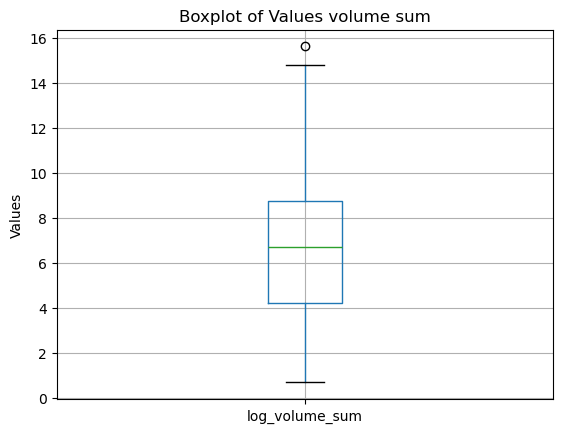

In [631]:

volume_sum_df.boxplot(column='log_volume_sum')

# Labeling the axes
plt.title('Boxplot of Values volume sum')
plt.ylabel('Values')

# Show the plot
plt.show()

In [655]:
# Step 1: Apply log transformation to the volume_sum
volume_sum_df['log_volume_sum'] = np.log1p(volume_sum_df['volume_sum'])

# Step 2: Create 5 equal-width bins based on the log-transformed data
volume_sum_df['volume_category'] = pd.cut(
    volume_sum_df['log_volume_sum'],   # The log-transformed volume data
    bins=5,                            # Number of bins
    labels=["Very Low", "Low", "Medium", "High", "Very High"]
)

# Display the resulting DataFrame with volume categories
print(volume_sum_df[['customer', 'volume_sum', 'log_volume_sum', 'volume_category']])

      customer  volume_sum  log_volume_sum volume_category
0            0           1        0.693147        Very Low
1            3      293321       12.589026            High
2            4        1315        7.182352          Medium
3            5         161        5.087596             Low
4            6           3        1.386294        Very Low
...        ...         ...             ...             ...
1065      2491         342        5.837730             Low
1066      2492        3634        8.198364          Medium
1067      2493          84        4.442651             Low
1068      2496         117        4.770685             Low
1069      2500       27348       10.216435            High

[1070 rows x 4 columns]


In [656]:
# creating 5 equal bins for the volume_sum
volume_sum_df['volume_category'].value_counts()

volume_category
Medium       362
Low          303
Very Low     228
High         159
Very High     18
Name: count, dtype: int64

Seeing if i can make a matrix that shows me what products are bought in combination with other. Possible could give me option to help cross selling

In [661]:
# Step 1. make a subset of the data for cross sell analysis
df_cross_sell = df_TY_users[['customer', 'invoice', 'artikelnr']].drop_duplicates()
df_cross_sell

,customer,invoice,artikelnr
0,2284,1187467,6439980
1,2284,1187467,6439981
2,2284,1187467,6420905
3,1704,1191447,8433401
4,45,1187691,7180136
...,...,...,...
492726,441,1596745,7050225
492727,2478,1596752,8530813
492728,2478,1596752,6223564
492729,2478,1596752,6220412


In [665]:
# Step 2. Group products by invoice to identify purchase combinatioins
invoice_products = df_cross_sell.groupby('invoice')['artikelnr'].apply(list)
invoice_products

invoice
1187460                               [7792831, 7793045]
1187467                      [6439980, 6439981, 6420905]
1187471                                        [3943684]
1187477    [6101653, 6303747, 7192479, 7122427, 7123147]
1187481                                        [4840609]
                               ...                      
2838110                      [7002813, 6204267, 6436342]
2882792                                        [6501018]
2886297                      [6203996, 6204127, 6203947]
2906136                                        [6501018]
2962232                                        [6501018]
Name: artikelnr, Length: 95498, dtype: object